In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<ipython-input-113-4c857d5876da>:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


라이브러리 불러오기

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

데이터 셋 불러오기

In [ ]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


데이터 셋 확인

In [ ]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

데이터 연결하기

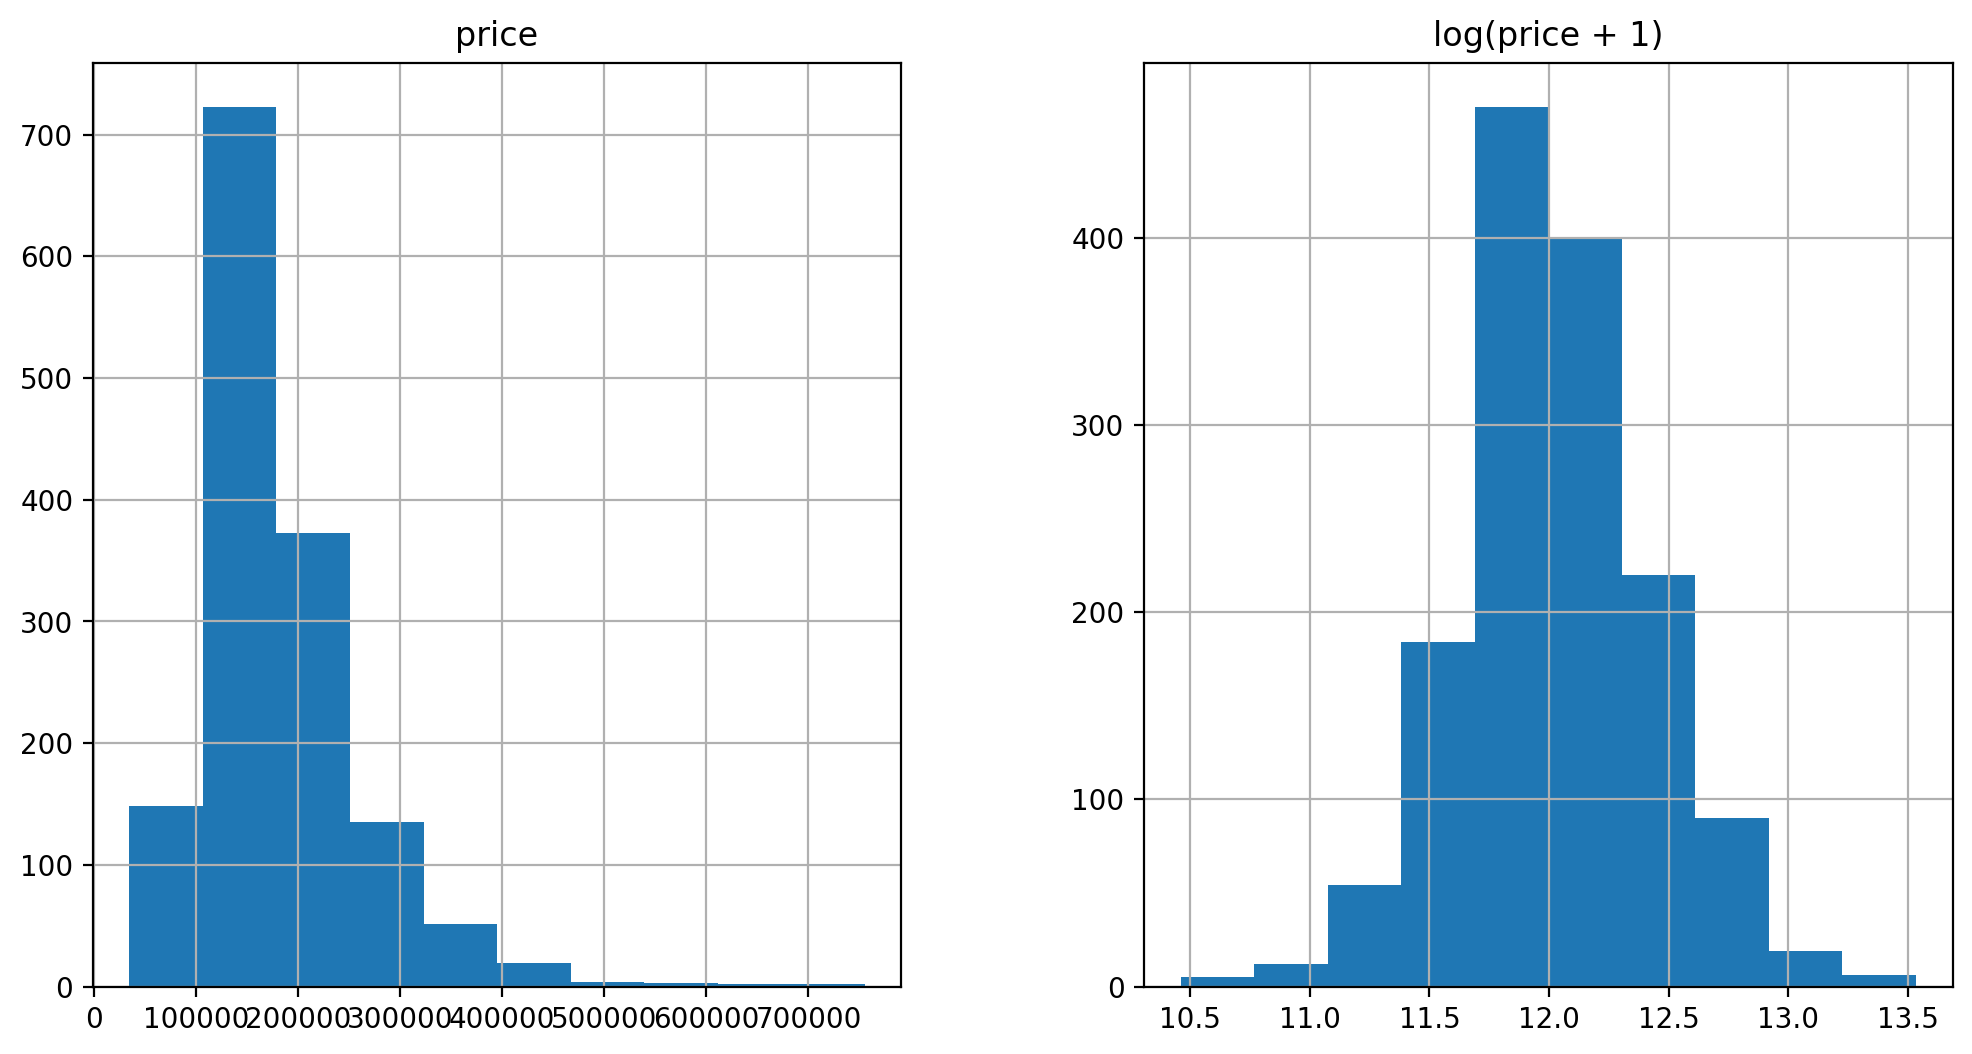

In [ ]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()
train["SalePrice"] = np.log1p(train["SalePrice"])

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

로그를 사용해 정규분포로 만들기

In [ ]:
all_data = pd.get_dummies(all_data)

원 핫 인코딩

In [ ]:
all_data = all_data.fillna(all_data.mean())

빈 값은 평균으로 메꿈

In [ ]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice
print(f'모든 데이터 : {len(all_data)}')
print(f'train 데이터 : {len(X_train)}')
print(f'test 데이터 : {len(X_test)}')

모든 데이터 : 2919
train 데이터 : 1460
test 데이터 : 1459


데이터 나누기

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

사이킷 런 모델 불러오기

In [ ]:
model_ridge = Ridge()

In [ ]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean()
            for alpha in alphas]

Text(0, 0.5, 'rmse')

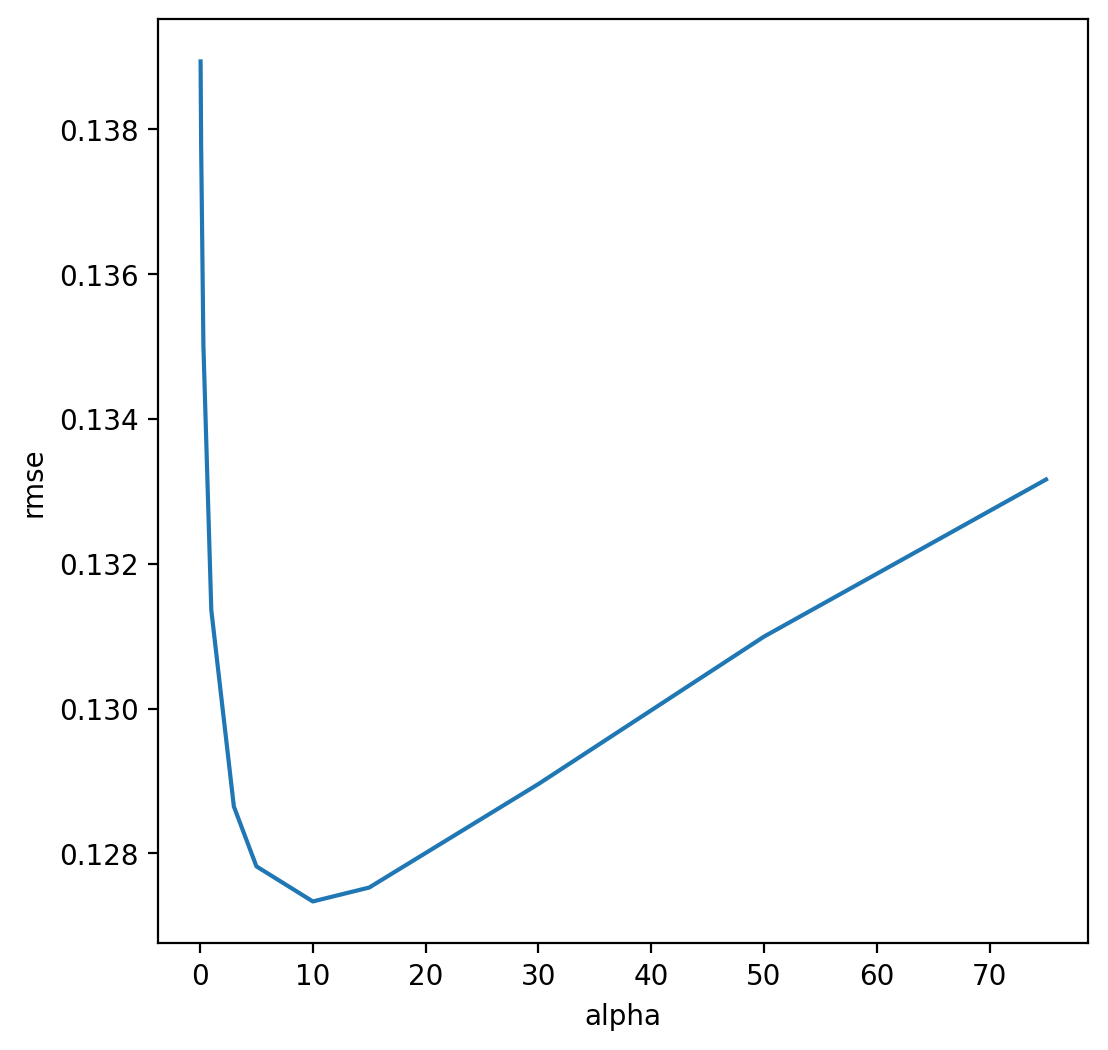

In [ ]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot()
plt.xlabel("alpha")
plt.ylabel("rmse")

In [ ]:
print(f"릿지 RMSE : {cv_ridge.min()}")

릿지 RMSE : 0.12733734668670768


릿지 사용

In [ ]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [ ]:
print(f"라쏘 RMSE : {rmse_cv(model_lasso).mean()}")

라쏘 RMSE : 0.12256735885048131


라쏘 사용

In [ ]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print( str(sum(coef != 0)) + "개의 변수 선택 " +  str(sum(coef == 0)) + " 변수 삭제")

110개의 변수 선택 178 변수 삭제


계수가 0인 변수 삭제

<Axes: >

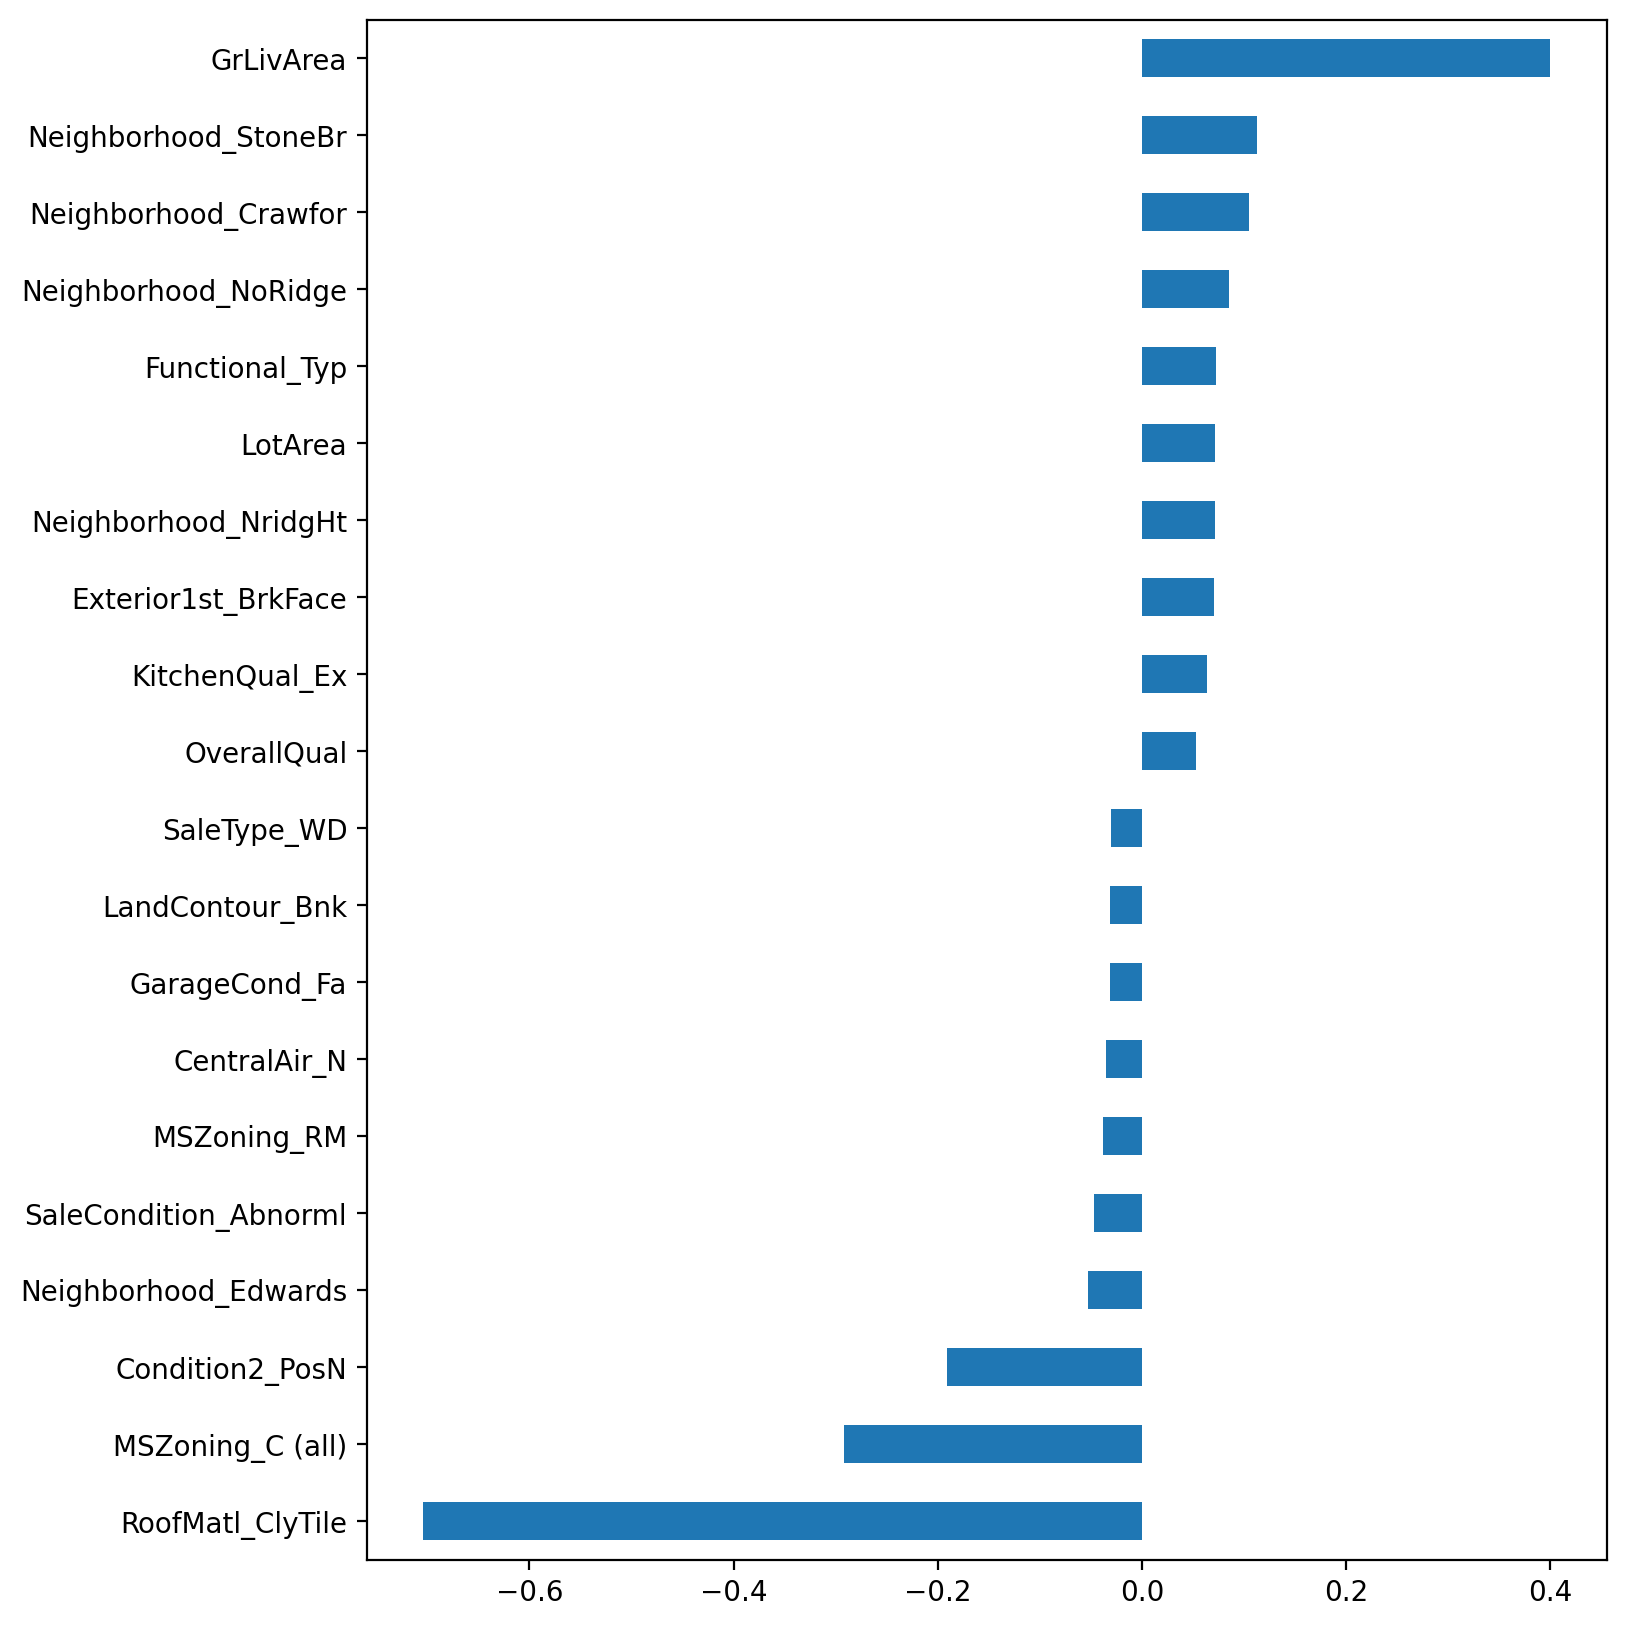

In [ ]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")

모델 계수 시각화

<Axes: xlabel='preds', ylabel='residuals'>

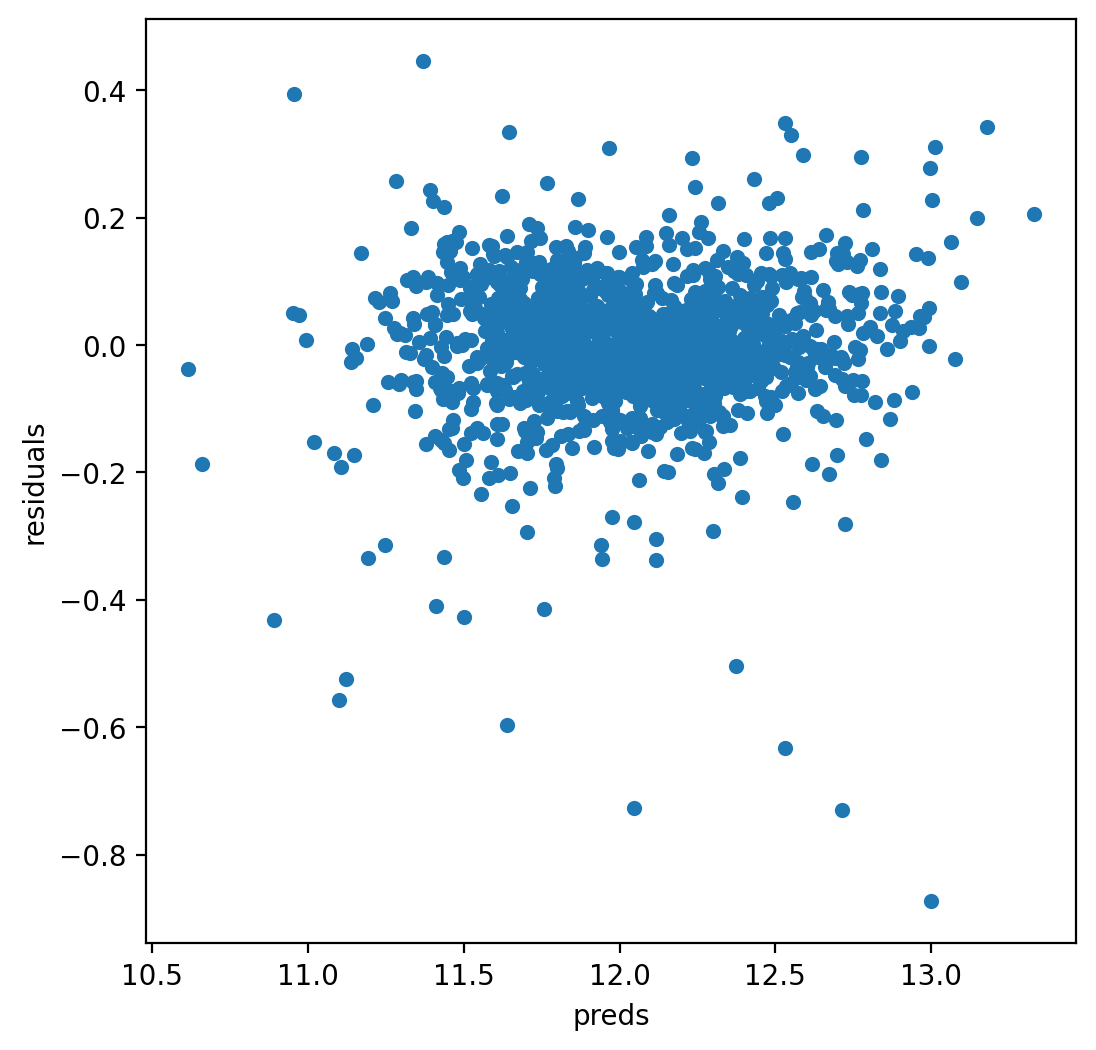

In [ ]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

잔차 시각화

In [ ]:
import xgboost as xgb

XGBoost 추가

In [ ]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

<Axes: >

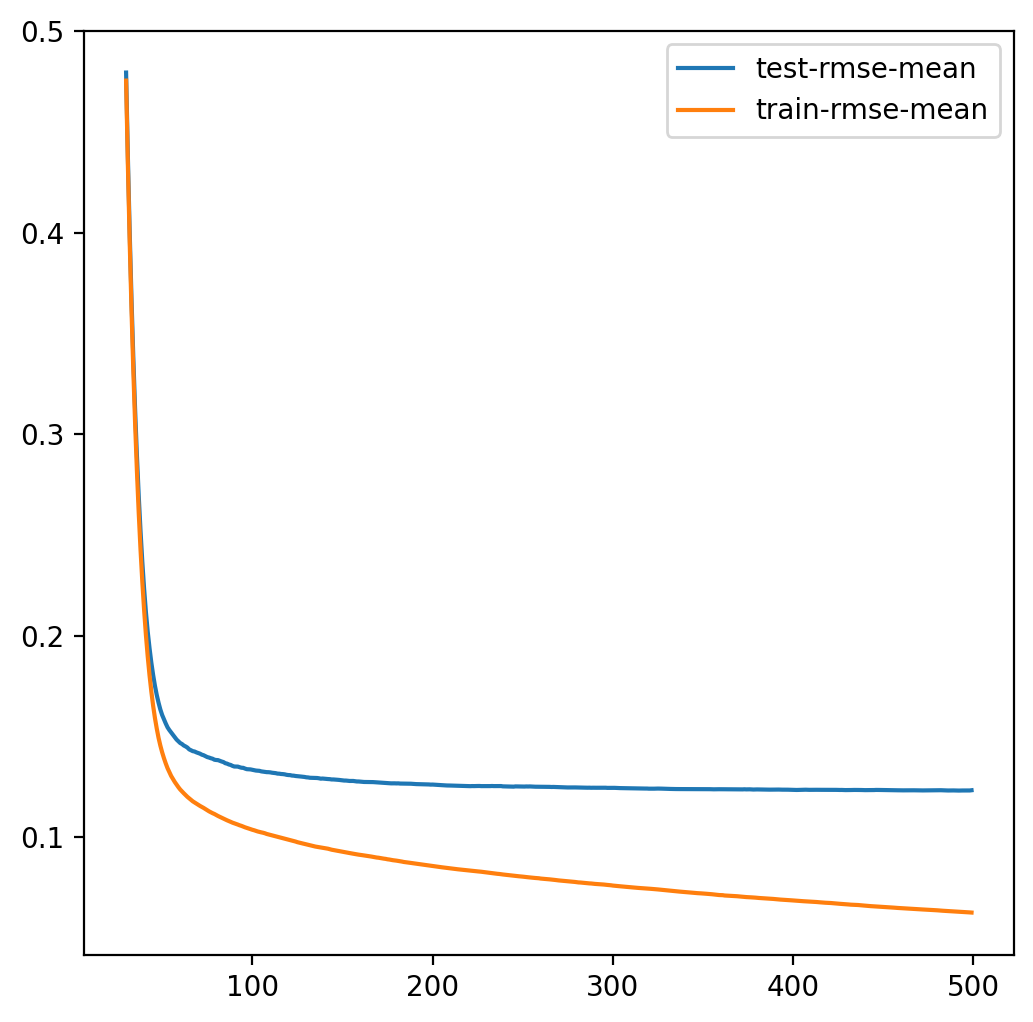

In [ ]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [ ]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1)
model_xgb.fit(X_train, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=360, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

XGBoost 사용

In [ ]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

<Axes: xlabel='xgb', ylabel='lasso'>

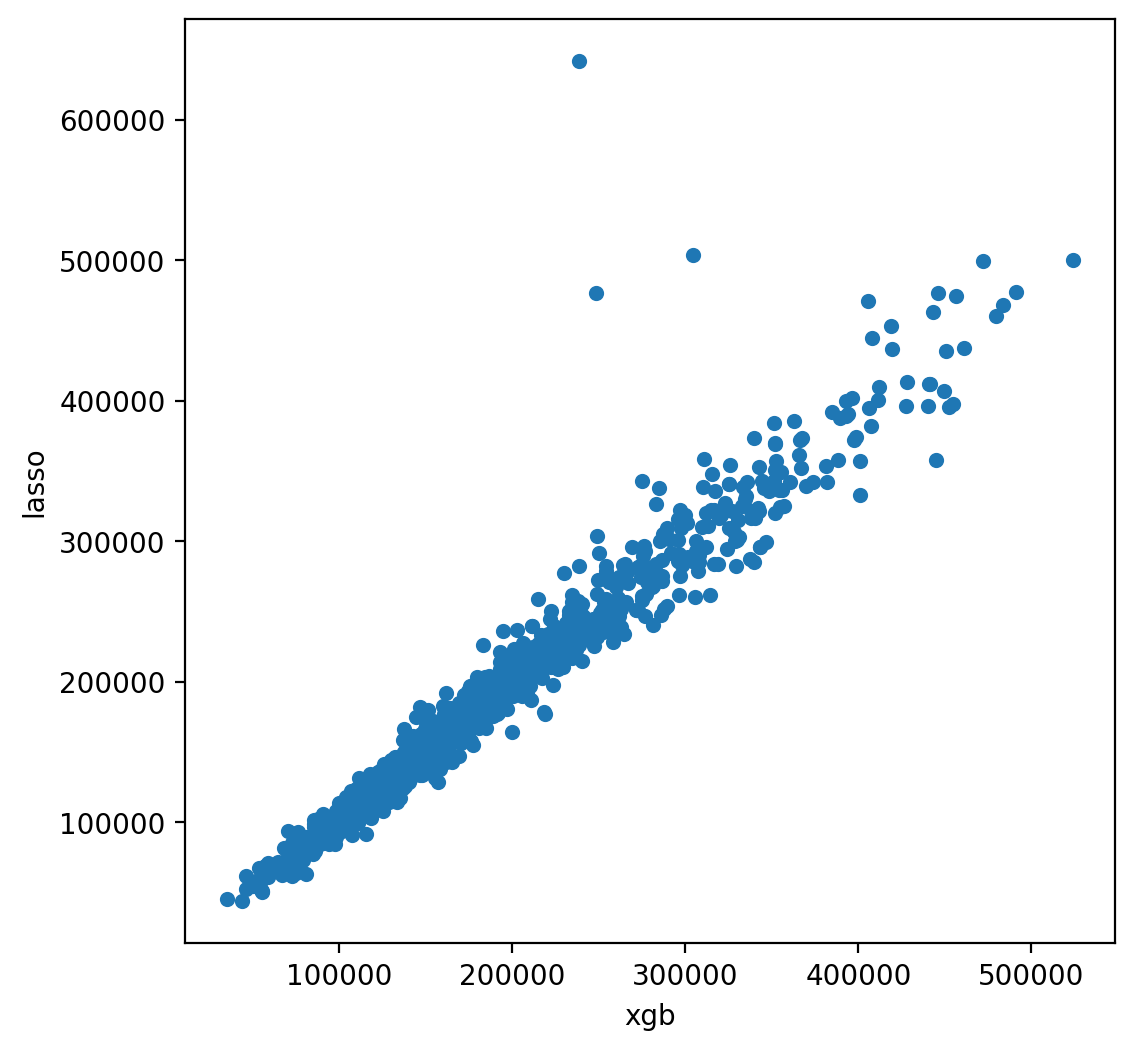

In [ ]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

In [ ]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

라쏘 예측값과 XGBoost 예측값 혼합

In [ ]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("submission.csv", index = False)
solution = pd.read_csv("submission.csv")
solution.head()

,id,SalePrice
0,1461,120038.976539
1,1462,152903.277594
2,1463,181963.136616
3,1464,195520.253748
4,1465,199062.535243


마무리